In [1]:
import numpy as np
from numpy import random
import torch as torch
from torch import nn
from torchvision import transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
torch.cuda.is_available()
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import tensorflow as tf
from torchvision.datasets import ImageFolder

In [2]:
torch.cuda.get_device_name(0)
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [31]:
generate_res = (64,64)
PHOTO_PATH = "./data"
DATA_PATH = "training.npy"
MODEL_PATH = "./newmodels"
SAVE_PATH = './newmodels'
SEED_SIZE = 128
BATCH_SIZE = 128
EPOCHS = 50     ## Increase this for better generated image 
img_width = 64
img_height = 64
channels = 3
n_critic = 5
learning_rate = 1e-4
beta1 = 0
beta2 = 0.9
latent_size = 128
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
# training_data = []
# for filename in tqdm(os.listdir(PHOTO_PATH)):
#     path = os.path.join(PHOTO_PATH,filename)
#     image = Image.open(path).resize((img_width,
#             img_height))
#     training_data.append(np.asarray(image))
# training_data = np.reshape(training_data,(-1,img_width,
#             img_height,channels))
# training_data = training_data.astype(np.float32)
# training_data = training_data / 127.5 - 1 #images should be normalised to [-1,1]
# print(np.shape(training_data))
# np.save("training.npy",training_data) 


# image_size = 64
# DATA_DIR = 'training.npy'
# X_train = np.load(DATA_DIR)
# print(f"Shape of training data: {X_train.shape}")
# print(f"Data type: {type(X_train)}")
# print(type(X_train[0][0][0][0]))
# data = X_train.astype(np.float64)
# data = 255 * data
# X_train = data.astype(np.uint8)
# print(type(X_train[0][0][0][0]))




train_ds = ImageFolder(PHOTO_PATH, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3, pin_memory=True)

In [5]:
class AnimeFaces(Dataset):
    def __init__(self, X):
        'Initialization'
        self.X = X
        
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.X[index]
        X = self.transform(image)
        return X
    
    transform = transforms.Compose([
        # Misc transforms here.
        transforms.ToPILImage(),
      
        transforms.ToTensor()
    ])

training_dataset = AnimeFaces(X_train)
training_data = DataLoader(training_dataset, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

In [6]:


# def show_images(images, nmax=64):
# #     print(images[0:2])
# #     images = images * 0.5 + 0.5
# #     print(images[0:2])
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax.set_xticks([]); ax.set_yticks([])
#     ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
# def show_batch(dl, nmax=64):
#     for images in dl:
#         show_images(images, nmax)
#         break

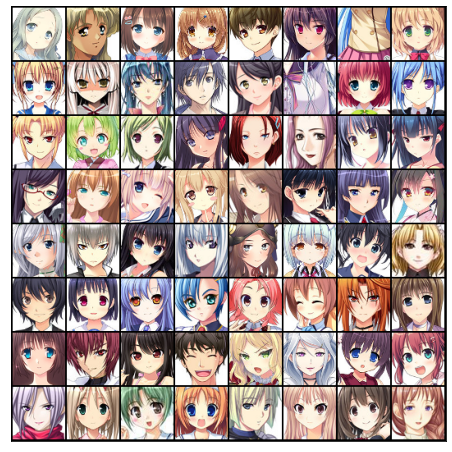

In [7]:
# print(training_data.shape)
# show_normal(training_data)
show_batch(train_dl)


In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [11]:
training_data = DeviceDataLoader(train_dl, device)

In [12]:


discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())


In [13]:
discriminator = to_device(discriminator, device)

In [14]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


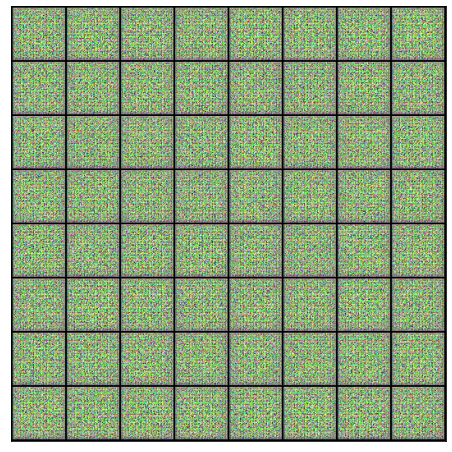

In [15]:
xb = torch.randn(BATCH_SIZE, SEED_SIZE, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [16]:
generator = to_device(generator, device)

In [19]:
def discriminator_loss(real_output,fake_output,penalty):
    return torch.mean(fake_output) - torch.mean(real_output) + penalty

def generator_loss(seed):
    fake_images = generator(seed)
    fake_output = discriminator(fake_images)
    return -torch.mean(fake_output)

generator_optimizer = torch.optim.Adam(params = discriminator.parameters(),lr = learning_rate,betas = (beta1,beta2)) 
#generator_optimizer = mixed_precision.LossScaleOptimizer(generator_optimizer, loss_scale='dynamic')

discriminator_optimizer = torch.optim.Adam(params = generator.parameters(),lr = learning_rate,betas = (beta1,beta2))

In [20]:
from torch.autograd import Variable


def gradient_penalty(real_images, fake_images):
    batch_size = real_images.size(0)
#     print("batch size in gp", batch_size)
    eta = torch.FloatTensor(batch_size,1,1,1).uniform_(0,1)
    eta = eta.expand(batch_size, real_images.size(1), real_images.size(2), real_images.size(3))
    
    eta = to_device(eta, device)
    interpolated = eta * real_images + ((1 - eta) * fake_images)


    # define it to calculate gradient
    interpolated = Variable(interpolated, requires_grad=True)

    # calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)
    grad_outputs = torch.ones_like(prob_interpolated)
    # calculate gradients of probabilities with respect to examples
    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=grad_outputs,
                           create_graph=True, retain_graph=True)[0]

    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() 
    return grad_penalty



# def gradient_penalty(real_data, fake_data):
    batch_size = real_data.size(0)
#     # Sample Epsilon from uniform distribution
#     eps = torch.rand(batch_size, 1, 1, 1)
#     eps = eps.expand_as(real_data)
# #     print("batch size in gp",batch_size,"fake data shape in gp", fake_data.shape)
#     # Interpolation between real data and fake data.
#     interpolation = eps * fake_data + (1 - eps) * real_data

#     # get logits for interpolated images
#     interp_logits = discriminator(interpolation)
#     grad_outputs = torch.ones_like(interp_logits)

#     # Compute Gradients
#     gradients = torch.autograd.grad(
#         outputs=interp_logits,
#         inputs=interpolation,
#         grad_outputs=grad_outputs,
#         create_graph=True,
#         retain_graph=True,
#     )[0]

#     # Compute and return Gradient Norm
#     gradients = gradients.view(batch_size, -1)
#     grad_norm = torch.linalg.norm(gradients,2, 1)
#     return torch.mean((grad_norm - 1) ** 2)
    

In [21]:



def train_discriminator(real_images, seed):
#     print("real image size", real_images.shape)
    fake_images = generator(seed)
    fake_images = to_device(fake_images, device)
    real_images = to_device(real_images, device)
#     print("fake image size", fake_images.shape)
#     print("in disc train")
    real_output = discriminator(real_images)
#     print("real_output size", real_output.shape)
#     print("after real output")
    fake_output = discriminator(fake_images)
#     print("after fake")
    g_penalty = gradient_penalty(real_images,fake_images)
    disc_loss = discriminator_loss(real_output,fake_output,g_penalty)
    discriminator_optimizer.zero_grad()
    disc_loss.backward()
    discriminator_optimizer.step()
    return  torch.mean(real_output),g_penalty



def train_generator(seed):
    gen_loss = generator_loss(seed)
        
    generator_optimizer.zero_grad()
    gen_loss.backward()
    generator_optimizer.step()
    return torch.mean(gen_loss)
    

In [22]:

def train(training_data, epochs):
  start = time.time()
  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []
    penalty_list = []
    i = 0
    for image_batch, _ in tqdm(training_data):
      
      batch_size = image_batch.size(0)
#       print("seed from batch sze", batch_size)
      seed = (np.random.normal(size=[batch_size, SEED_SIZE,1,1]).astype("float32"))
#       seed = SEED_SIZE
      seed = torch.from_numpy(seed)
      seed = to_device(seed, device)
      
      disc_loss, penalty = train_discriminator(image_batch,seed)
      disc_loss_list.append(disc_loss)
      penalty_list.append(penalty)
#       print("Discriminator loss", disc_loss)
   

      if i % n_critic == 0:
        gen_loss = train_generator(seed)
        gen_loss_list.append(gen_loss)
#         print("Generator loss", gen_loss)
      i = i + 1;
    torch.save(generator.state_dict(), './pytorchmodels')  
    torch.save(discriminator.state_dict(), './pytorchmodels') 
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)
    penalty = sum(penalty_list) / len(penalty_list)
    
#     if epoch%5 == 0:
        
#         generator.save(os.path.join(SAVE_PATH,"face_generator.h5"))
#         discriminator.save(os.path.join(SAVE_PATH,"face_discriminator.h5"))

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, fake output={g_loss},real output={d_loss}, penalty = {penalty}, {epoch_elapsed}')
        

  elapsed = time.time()-start
  print (f'Training time: {(elapsed)}')

In [23]:
train(training_data,250)

Epoch 1, fake output=-0.4999989867210388,real output=0.6124148964881897, penalty = 0.9998738169670105, 56.78849267959595
Epoch 2, fake output=-0.5,real output=0.6307963728904724, penalty = 0.9998682141304016, 40.90473031997681
Epoch 3, fake output=-0.5,real output=0.6311016082763672, penalty = 0.9998680949211121, 42.029711961746216
Epoch 4, fake output=-0.5,real output=0.6314988136291504, penalty = 0.9998680353164673, 42.67353963851929
Epoch 5, fake output=-0.5,real output=0.631889283657074, penalty = 0.9998679161071777, 42.88808465003967
Epoch 6, fake output=-0.5,real output=0.6321828961372375, penalty = 0.9998677372932434, 43.15555715560913
Epoch 7, fake output=-0.5,real output=0.6324527263641357, penalty = 0.9998676776885986, 43.213897466659546
Epoch 8, fake output=-0.5,real output=0.632682204246521, penalty = 0.9998675584793091, 43.1712760925293
Epoch 9, fake output=-0.5,real output=0.6328824162483215, penalty = 0.9998674988746643, 43.422162771224976
Epoch 10, fake output=-0.5,real

Epoch 78, fake output=-0.5,real output=0.6350765228271484, penalty = 0.9998672008514404, 42.25483965873718
Epoch 79, fake output=-0.5,real output=0.635065495967865, penalty = 0.9998670816421509, 42.33081650733948
Epoch 80, fake output=-0.5,real output=0.6350757479667664, penalty = 0.9998670816421509, 42.1426477432251
Epoch 81, fake output=-0.5,real output=0.6350818276405334, penalty = 0.9998670816421509, 42.34919190406799
Epoch 82, fake output=-0.5,real output=0.6350734829902649, penalty = 0.9998670816421509, 42.257264852523804
Epoch 83, fake output=-0.5,real output=0.6351118087768555, penalty = 0.9998670816421509, 42.383206605911255
Epoch 84, fake output=-0.5,real output=0.6350935101509094, penalty = 0.9998670816421509, 42.46340727806091
Epoch 85, fake output=-0.5,real output=0.6351022720336914, penalty = 0.9998670816421509, 42.4826865196228
Epoch 86, fake output=-0.5,real output=0.6350928544998169, penalty = 0.9998670816421509, 42.18876886367798
Epoch 87, fake output=-0.5,real output

Epoch 155, fake output=-0.5,real output=0.6355187296867371, penalty = 0.9998670220375061, 42.8540096282959
Epoch 156, fake output=-0.5,real output=0.6355505585670471, penalty = 0.9998670220375061, 43.004807233810425
Epoch 157, fake output=-0.5,real output=0.6355192065238953, penalty = 0.9998669028282166, 42.97922968864441
Epoch 158, fake output=-0.5,real output=0.6355363130569458, penalty = 0.9998670220375061, 42.988977909088135
Epoch 159, fake output=-0.5,real output=0.6355218291282654, penalty = 0.9998670220375061, 42.82576847076416
Epoch 160, fake output=-0.5,real output=0.6355152726173401, penalty = 0.9998670220375061, 43.07477116584778
Epoch 161, fake output=-0.5,real output=0.6355208158493042, penalty = 0.9998670220375061, 42.976966381073
Epoch 162, fake output=-0.5,real output=0.6355315446853638, penalty = 0.9998670220375061, 42.92530608177185
Epoch 163, fake output=-0.5,real output=0.6355513334274292, penalty = 0.9998670220375061, 43.07432174682617
Epoch 164, fake output=-0.5,r

Epoch 231, fake output=-0.5,real output=0.6357038021087646, penalty = 0.9998669028282166, 44.34175729751587
Epoch 232, fake output=-0.5,real output=0.6357075572013855, penalty = 0.9998669028282166, 44.33460474014282
Epoch 233, fake output=-0.5,real output=0.6357002854347229, penalty = 0.9998670220375061, 44.32589340209961
Epoch 234, fake output=-0.5,real output=0.635695219039917, penalty = 0.9998669028282166, 44.16211557388306
Epoch 235, fake output=-0.5,real output=0.6357020139694214, penalty = 0.9998670220375061, 44.18923997879028
Epoch 236, fake output=-0.5,real output=0.6357508897781372, penalty = 0.9998668432235718, 44.292362689971924
Epoch 237, fake output=-0.5,real output=0.6357635259628296, penalty = 0.9998668432235718, 44.35131025314331
Epoch 238, fake output=-0.5,real output=0.6357443332672119, penalty = 0.9998668432235718, 44.02387261390686
Epoch 239, fake output=-0.5,real output=0.635748028755188, penalty = 0.9998667240142822, 44.455735206604004
Epoch 240, fake output=-0.5,

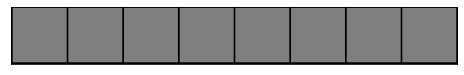

In [27]:
import matplotlib.pyplot as plt
noise = torch.rand((8,128,1,1))
noise = to_device(noise, device)
generated_image = generator(noise)
generated_image = denorm(generated_image)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(generated_image.cpu().detach(), nrow=8).permute(1, 2, 0))